**Import Necessary Libraries:**

In [21]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


# Synthetic Data generation
# > - These functions are used to generate synthetic data for a customer churn analysis

In [2]:
def generate_customer_id(size):
    return np.arange(1, size + 1)

def generate_age(size):
    return np.random.randint(18, 80, size)

def generate_gender(size):
    return np.random.choice(['Male', 'Female'], size)

def generate_contract_type(size):
    return np.random.choice(['Month-to-month', 'One year', 'Two year'], size)

def generate_monthly_charges(size):
    return np.random.uniform(30, 100, size)

def generate_total_charges(size, monthly_charges, tenure):
    return monthly_charges * tenure

def generate_tech_support(size):
    return np.random.choice(['Yes', 'No'], size)

def generate_internet_service(size):
    return np.random.choice(['DSL', 'Fiber optic', 'No'], size)

def generate_tenure(size):
    return np.random.randint(1, 72, size)

def generate_paperless_billing(size):
    return np.random.choice(['Yes', 'No'], size)

def generate_payment_method(size):
    return np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], size)

def generate_churn(size, churn_rate=0.2):
    return np.random.choice(['Yes', 'No'], size, p=[churn_rate, 1 - churn_rate])

def introduce_missing_values(df, missing_rate=0.05):
    for column in df.columns:
        if column not in ['CustomerID', 'Churn']:
            mask = np.random.rand(len(df)) < missing_rate
            df.loc[mask, column] = np.nan
    return df

def introduce_outliers(df, outlier_rate=0.01):
    for column in ['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure']:
        mask = np.random.rand(len(df)) < outlier_rate
        df.loc[mask, column] = df[column].max() * 10
    return df

def introduce_inconsistencies(df, inconsistency_rate=0.01):
    for column in ['Gender', 'ContractType', 'InternetService', 'PaymentMethod']:
        mask = np.random.rand(len(df)) < inconsistency_rate
        df.loc[mask, column] = 'Unknown'
    return df

**Calling out the defined function:**



In [3]:
size = 5000 # records
data = {
    'CustomerID': generate_customer_id(size),
    'Age': generate_age(size),
    'Gender': generate_gender(size),
    'ContractType': generate_contract_type(size),
    'MonthlyCharges': generate_monthly_charges(size),
    'Tenure': generate_tenure(size),
    'TechSupport': generate_tech_support(size),
    'InternetService': generate_internet_service(size),
    'PaperlessBilling': generate_paperless_billing(size),
    'PaymentMethod': generate_payment_method(size),
    'Churn': generate_churn(size)
}

df = pd.DataFrame(data)
df['TotalCharges'] = generate_total_charges(size, df['MonthlyCharges'], df['Tenure'])

# Introduce data quality issues
df = introduce_missing_values(df)
df = introduce_outliers(df)
df = introduce_inconsistencies(df)

# Create derived features
df['AverageMonthlyCharges'] = df['TotalCharges'] / df['Tenure']
df['CustomerLifetimeValue'] = df['MonthlyCharges'] * df['Tenure']

# Display the first few rows of the dataset
print(df.head())


   CustomerID    Age  Gender    ContractType  MonthlyCharges  Tenure  \
0           1   56.0    Male        Two year       51.553562    21.0   
1           2   49.0  Female  Month-to-month       42.554368    38.0   
2           3   74.0    Male        Two year       30.459775    20.0   
3           4   73.0    Male        One year       50.969914    59.0   
4           5  790.0    Male        One year       32.873697    44.0   

  TechSupport InternetService PaperlessBilling     PaymentMethod Churn  \
0          No              No              Yes      Mailed check    No   
1          No              No              Yes  Electronic check    No   
2         Yes             DSL              Yes  Electronic check   Yes   
3         Yes             DSL               No               NaN   Yes   
4          No             DSL               No      Mailed check    No   

   TotalCharges  AverageMonthlyCharges  CustomerLifetimeValue  
0   1082.624801              51.553562            1082.624

**Checking the data quality**

#Missing Values:


In [4]:
print(df.isnull().sum())

CustomerID                 0
Age                      235
Gender                   251
ContractType             260
MonthlyCharges           230
Tenure                   234
TechSupport              271
InternetService          251
PaperlessBilling         244
PaymentMethod            267
Churn                      0
TotalCharges             245
AverageMonthlyCharges    469
CustomerLifetimeValue    455
dtype: int64


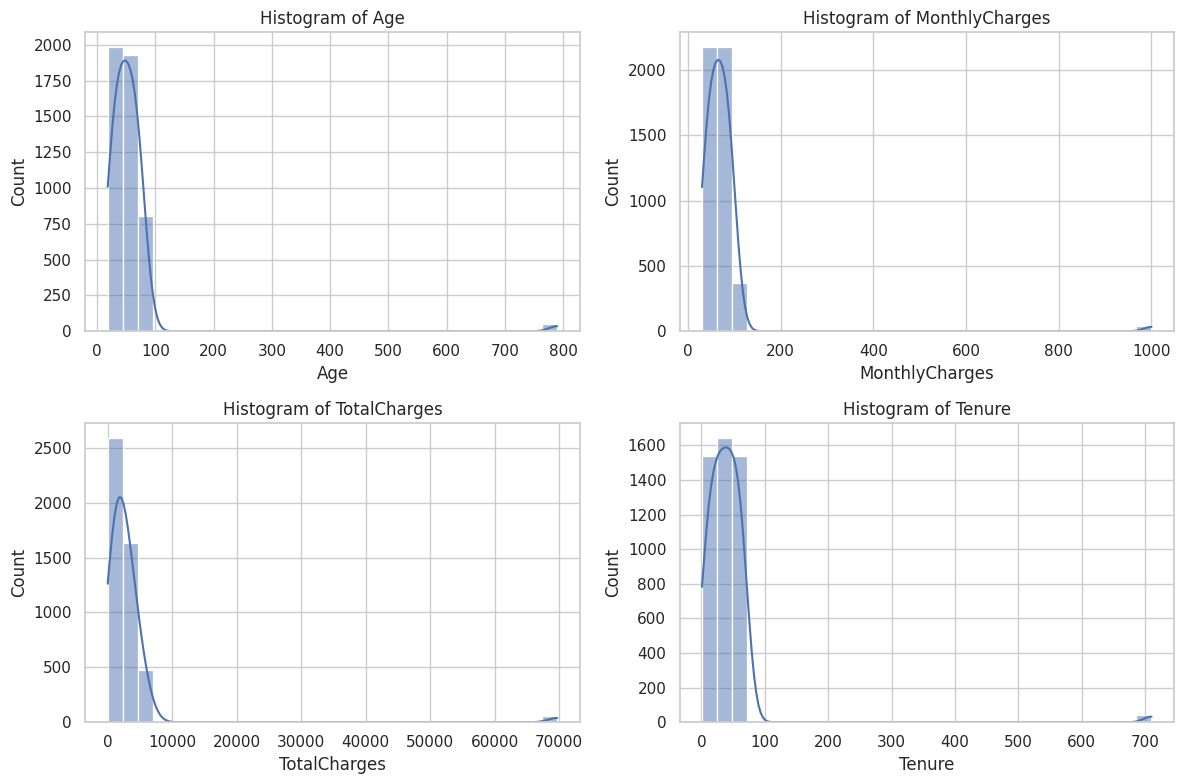

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


plt.figure(figsize=(12, 8))
for i, column in enumerate(['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

**Unique Values**


In [6]:
for column in ['Gender', 'ContractType', 'InternetService', 'PaymentMethod']:
    print(f" {column}: {df[column].unique()}")


 Gender: ['Male' 'Female' nan 'Unknown']
 ContractType: ['Two year' 'Month-to-month' 'One year' nan 'Unknown']
 InternetService: ['No' 'DSL' 'Fiber optic' 'Unknown' nan]
 PaymentMethod: ['Mailed check' 'Electronic check' nan 'Bank transfer' 'Credit card'
 'Unknown']


**Fill missing values for numerical columns with the mean**


In [7]:
numerical_columns = ['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'AverageMonthlyCharges', 'CustomerLifetimeValue']
for column in numerical_columns:
    df[column].fillna(df[column].mean(), inplace=True)


**Fill missing values for categorical columns with the mode**


In [8]:
categorical_columns = ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod']
for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Verify that there are no missing values left
print(df.isnull().sum())

CustomerID               0
Age                      0
Gender                   0
ContractType             0
MonthlyCharges           0
Tenure                   0
TechSupport              0
InternetService          0
PaperlessBilling         0
PaymentMethod            0
Churn                    0
TotalCharges             0
AverageMonthlyCharges    0
CustomerLifetimeValue    0
dtype: int64


**label encoding for categorical features to convert them into numerical format**.


In [9]:
label_encoder = LabelEncoder()


for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df['Churn'] = label_encoder.fit_transform(df['Churn'])

**checking missing values**


In [10]:
df.isnull().sum()

,0
CustomerID,0
Age,0
Gender,0
ContractType,0
MonthlyCharges,0
Tenure,0
TechSupport,0
InternetService,0
PaperlessBilling,0
PaymentMethod,0


 **modeling**


**test train split 80 | 20 ratio**

In [11]:
from sklearn.model_selection import train_test_split


X = df.drop(['CustomerID', 'Churn'], axis=1)
y = df['Churn']

X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [12]:
# Create interaction terms
df['MonthlyCharges_Tenure'] = df['MonthlyCharges'] * df['Tenure']
df['Age_Tenure'] = df['Age'] * df['Tenure']

# Update the feature set
X_train_full['MonthlyCharges_Tenure'] = X_train_full['MonthlyCharges'] * X_train_full['Tenure']
X_train_full['Age_Tenure'] = X_train_full['Age'] * X_train_full['Tenure']

X_val['MonthlyCharges_Tenure'] = X_val['MonthlyCharges'] * X_val['Tenure']
X_val['Age_Tenure'] = X_val['Age'] * X_val['Tenure']

X_test['MonthlyCharges_Tenure'] = X_test['MonthlyCharges'] * X_test['Tenure']
X_test['Age_Tenure'] = X_test['Age'] * X_test['Tenure']

**Model Building**


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


**Random Forest**


In [14]:

# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='precision', n_jobs=-1)
grid_search_rf.fit(X_train_full, y_train_full)

best_rf = grid_search_rf.best_estimator_

# Evaluate on validation set
y_val_pred_rf = best_rf.predict(X_val)
print("Random Forest Validation Results:")
print(classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall:", recall_score(y_val, y_val_pred_rf))
print("F1 Score:", f1_score(y_val, y_val_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_pred_rf))


Random Forest Validation Results:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       399
           1       0.22      0.05      0.08       101

    accuracy                           0.77       500
   macro avg       0.51      0.50      0.48       500
weighted avg       0.68      0.77      0.71       500

Confusion Matrix:
[[381  18]
 [ 96   5]]
Precision: 0.21739130434782608
Recall: 0.04950495049504951
F1 Score: 0.08064516129032258
ROC AUC Score: 0.5021960842700812


**Logistic Regression**


In [15]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_full, y_train_full)

# Evaluate on validation set
y_val_pred_log_reg = log_reg.predict(X_val)
print("Logistic Regression Validation Results:")
print(classification_report(y_val, y_val_pred_log_reg))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_log_reg))
print("Precision:", precision_score(y_val, y_val_pred_log_reg))
print("Recall:", recall_score(y_val, y_val_pred_log_reg))
print("F1 Score:", f1_score(y_val, y_val_pred_log_reg))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_pred_log_reg))

Logistic Regression Validation Results:
              precision    recall  f1-score   support

           0       0.79      0.55      0.65       399
           1       0.19      0.42      0.26       101

    accuracy                           0.53       500
   macro avg       0.49      0.48      0.46       500
weighted avg       0.67      0.53      0.57       500

Confusion Matrix:
[[221 178]
 [ 59  42]]
Precision: 0.19090909090909092
Recall: 0.4158415841584158
F1 Score: 0.26168224299065423
ROC AUC Score: 0.48486314796893226


**Gradient Bossting**


In [16]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=3, scoring='precision', n_jobs=-1)
grid_search_gb.fit(X_train_full, y_train_full)

best_gb = grid_search_gb.best_estimator_

# Evaluate on validation set
y_val_pred_gb = best_gb.predict(X_val)
print("Gradient Boosting Validation Results:")
print(classification_report(y_val, y_val_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_gb))
print("Precision:", precision_score(y_val, y_val_pred_gb))
print("Recall:", recall_score(y_val, y_val_pred_gb))
print("F1 Score:", f1_score(y_val, y_val_pred_gb))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_pred_gb))

Gradient Boosting Validation Results:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       399
           1       0.00      0.00      0.00       101

    accuracy                           0.79       500
   macro avg       0.40      0.50      0.44       500
weighted avg       0.64      0.79      0.71       500

Confusion Matrix:
[[397   2]
 [101   0]]
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.4974937343358396


> ###  **XG Boost**


In [22]:
# Initialize XGBoost model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='precision', n_jobs=-1)
grid_search_xgb.fit(X_train_full, y_train_full)

# Get the best model
best_xgb = grid_search_xgb.best_estimator_

# Evaluate on validation set
y_val_pred_xgb = best_xgb.predict(X_val)

# Print evaluation metrics
print("XGBoost Validation Results:")
print(classification_report(y_val, y_val_pred_xgb, zero_division=1))  # Handle division by zero
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_xgb))
print("Precision:", precision_score(y_val, y_val_pred_xgb, zero_division=1))
print("Recall:", recall_score(y_val, y_val_pred_xgb, zero_division=1))
print("F1 Score:", f1_score(y_val, y_val_pred_xgb, zero_division=1))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_pred_xgb))


XGBoost Validation Results:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       399
           1       1.00      0.00      0.00       101

    accuracy                           0.80       500
   macro avg       0.90      0.50      0.44       500
weighted avg       0.84      0.80      0.71       500

Confusion Matrix:
[[399   0]
 [101   0]]
Precision: 1.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5


**Model Selection and Evaluation**


In [24]:
# Compare precision scores of the models on the validation set
precision_scores = {
    'Logistic Regression': precision_score(y_val, y_val_pred_log_reg),
    'Random Forest': precision_score(y_val, y_val_pred_rf),
    'Gradient Boosting': precision_score(y_val, y_val_pred_gb),
    'XGBoost': precision_score(y_val, y_val_pred_xgb)
}

# Select the model with the highest precision
best_model_name = max(precision_scores, key=precision_scores.get)
best_model = {
    'Logistic Regression': log_reg,
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'XGBoost': best_xgb
}[best_model_name]

print(f"The best model based on precision is: {best_model_name}")


The best model based on precision is: Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Evaluate the best model on the test set
best_model = best_xgb  # Replace with the best model based on validation results
y_test_pred = best_model.predict(X_test)

print("Best Model Test Results:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_test_pred))


Best Model Test Results:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88       399
           1       0.25      0.01      0.02       101

    accuracy                           0.79       500
   macro avg       0.52      0.50      0.45       500
weighted avg       0.69      0.79      0.71       500

Confusion Matrix:
[[396   3]
 [100   1]]
Precision: 0.25
Recall: 0.009900990099009901
F1 Score: 0.019047619047619046
ROC AUC Score: 0.5011910965532643


**Feature Importance**

                  Feature  Importance
1                  Gender    0.101959
11  CustomerLifetimeValue    0.089319
2            ContractType    0.082713
4                  Tenure    0.078971
13             Age_Tenure    0.074782
10  AverageMonthlyCharges    0.074383
3          MonthlyCharges    0.071069
8           PaymentMethod    0.070000
6         InternetService    0.063728
7        PaperlessBilling    0.061173
0                     Age    0.058524
12  MonthlyCharges_Tenure    0.058041
9            TotalCharges    0.057764
5             TechSupport    0.057573


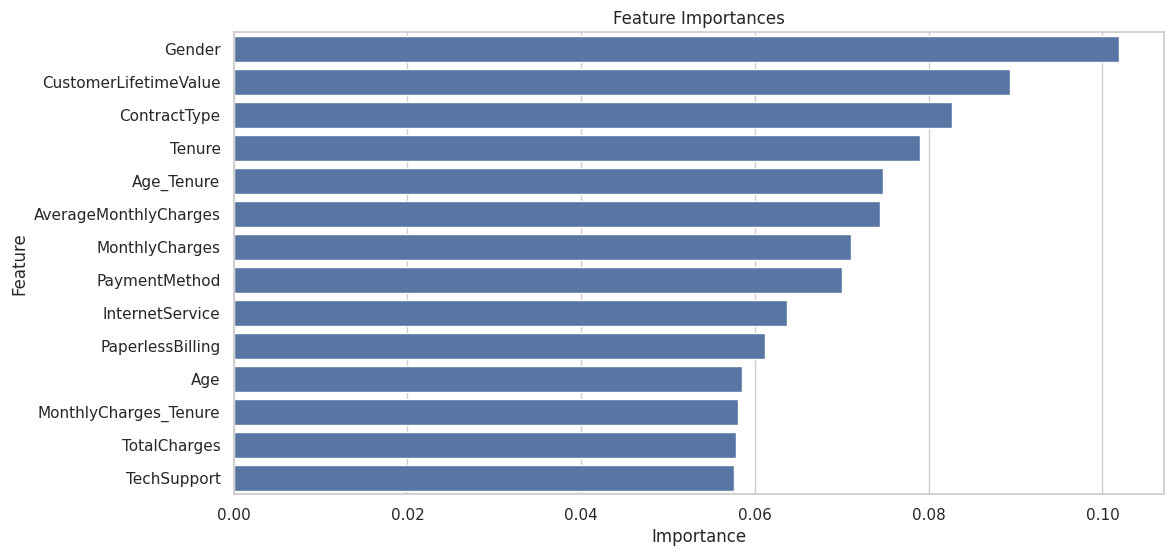

In [26]:
if isinstance(best_model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)):
    feature_importances = best_model.feature_importances_
    feature_names = X_train_full.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)

    # Plot feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances')
    plt.show()
